In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import tensorflow as tf
plt.style.use("ggplot")

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [32]:
import pandas as pd

In [27]:
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr

In [103]:
from autograd import grad

### Inverse Problem

Reference paper `Mixture Density Network - C.Bishop`

Suppose we have the following mapping from `t` to `x`

In [59]:
N = 200
t = np.linspace(0, 1, N)
x = t + 0.3 * np.sin(2*3.1415926*t) + np.random.uniform(-0.1, 0.1, N)

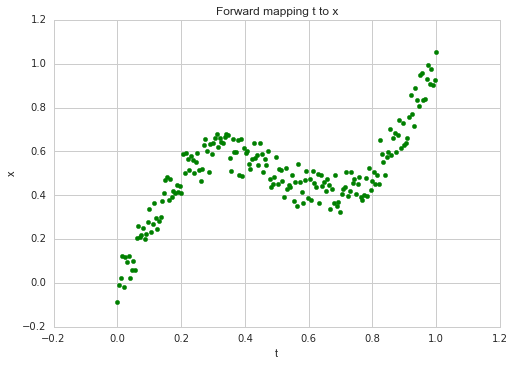

In [60]:
plt.scatter(t, x, color='g');
plt.title('Forward mapping t to x');
plt.xlabel('t');
plt.ylabel('x');

We can use neural network to learn this mapping by minimizing a sum-of-squares error function. This results in an approximate function to the true one, which is the approximation of the conditional mean given the input. 

But what if we want to learn the inverse mapping from `x` to `t`. Obviously, this is multi-valued mapping since one value of `x` correspond to at least one of `t`. The previously optimal conditional average no longer be optimal in such case, for instance, in the region `x` within `0.48` and `0.52`, the mean of `t = 0.48`, which is a poor reflection of multi-modal density of `t`, which has 3 modes.

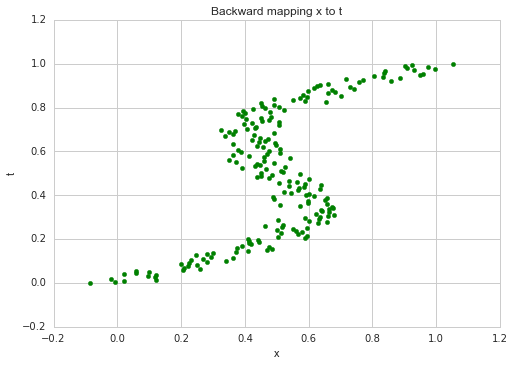

In [321]:
plt.scatter(x, t, color='g');
plt.title('Backward mapping x to t');
plt.xlabel('x');
plt.ylabel('t');

In [323]:
data = pd.DataFrame({'x': x, 't': t})

In [63]:
data[(data['x'] > 0.48) & (data['x'] < 0.52)].mean()

t    0.486731
x    0.500000
dtype: float64

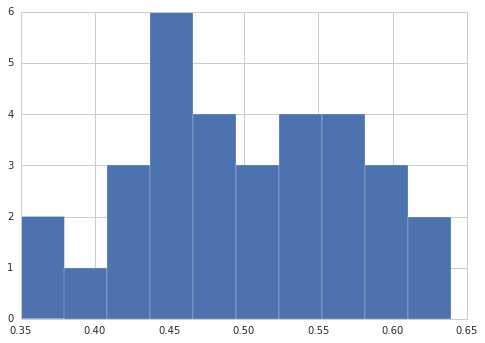

In [71]:
data.loc[(data['x'] > 0.42) & (data['x'] < 0.58), 't'].hist(bins=10);

The result we want is not the conditional mean but the conditional density of `t` given `x`.

`[?]` How to learn a probability density function?

The idea is to use `Mixture of Gaussian`, whose representation can approximate any given density with the need to specify full covariance matrix

$$ p(t|x) = \sum^m_{i=1} \alpha_i(x) . \phi_i(t|x) $$

where $\alpha_i$ is the mixing weights, sum up to 1, $\phi_i$ is the `component distribution`, specified as Gaussian.

The interesting aspect of this model is that both the mixing weights and the parameters of component distribution are specified to be function of `x`. And we use NN to model these functions since NN are universal approximators.

Another trick we use for modeling $\alpha$ is that we model them as continuous variables outputted from NN, then we use `softmax transformation` to scale them into `[0, 1]` and make them sum up to 1.

So basically, we have the following likelihood function

$$ p(t|x) = \sum^m_{i=1} \alpha_i(x) . \phi_i(t|x) $$

where

$$ \phi_i(t|x) = (2\pi . \sigma(x)^2)^{-0.5} . \exp({-\frac{(x - \mu(x))^2}{2\sigma^2} }) $$

$$ \alpha_i(x) = \frac{\exp(z_i^{\sigma})}{\sum_i \exp(z_i^{\sigma})}  $$

$ z_i^{\sigma} $ is the network output for $\sigma$

The parameters of the problems are the weights of NN, in order to estimate these weights, we can use `Maximum Likelihood Estimation`

In [506]:
def mdn_loss(parameters):
    w1 = parameters[0]
    w2 = parameters[1]
    b1 = parameters[2]
    b2 = parameters[3]
    
    no_train = data['x'].shape[0]
    no_dim   = w1.shape[0]
    no_component = 3
    
    # FORWARD
    # reshape in case no_dim = 1
    h1 = np.dot(data['x'].values.reshape((no_train, no_dim)), w1) + b1   # 200 x 20
    z1 = np.tanh(h1)

    h2 = np.dot(z1, w2) + b2  # 200 x 9
    z2 = h2

    # first 3 is for mixing weights, next 3 is for mean, last 3 is for std
    # transformation
    softmax = lambda e: np.exp(e) / np.sum(np.exp(e))
    alpha   = np.array([softmax(alpha_) for alpha_ in z2[:, :no_component]])
    # use iteration instead of indexing
    mu      = np.array([m_ for m_ in z2[:, no_component:no_component*2]])     
    sigma   = np.array([np.exp(s_) for s_ in z2[:, no_component*2:]])

    # accepts vectors and produce a vector of gaussian density
    gaussian = lambda x, m, s: (np.sqrt(2*np.pi)*s)**-1.0 * np.exp(-0.5*(x - m)**2/s**2)
    for i in range(no_component):
        if i == 0: 
            components = np.array([gaussian(t_, mu_, s_) \
            for t_, mu_, s_ in zip(data['t'], mu[:, i], sigma[:, i])]).reshape( (no_train, 1) )
        else: 
            components = np.concatenate( (components, np.array([gaussian(t_, mu_, s_) \
            for t_, mu_, s_ in zip(data['t'], mu[:, i], sigma[:, i])]).reshape( (no_train, 1) )), axis=1)

    loss = -np.sum(np.log(np.sum(alpha * components, axis=1))) # axis=1 sum over rows
    return loss

grad_loss = grad(mdn_loss)

In [548]:
def mdn_loss_analytics(parameters):
    w1 = parameters[0]
    w2 = parameters[1]
    b1 = parameters[2]
    b2 = parameters[3]
    
    no_train = data['x'].shape[0]
    no_dim   = w1.shape[0]
    no_component = 3
    
    # FORWARD
    # reshape in case no_dim = 1
    h1 = np.dot(np.reshape(data['x'].values, (no_train, no_dim)), np.reshape(w1, (no_dim, no_hidden))) + b1   # 200 x 20
    z1 = np.tanh(h1)
    h2 = np.dot(z1, w2) + b2  # 200 x 9
    z2 = h2

    # first 3 is for mixing weights, next 3 is for mean, last 3 is for std
    # transformation
    softmax = lambda e: np.exp(e) / np.sum(np.exp(e))
    alpha   = np.array([softmax(e) for e in z2[:, :no_component]])   # za
    mu      = z2[:, no_component:no_component*2]                     # zm
    sigma   = np.exp(z2[:, no_component*2:])                         # zs

    # accepts vectors and produce a vector of gaussian density
    gaussian = lambda x, m, s: (np.sqrt(2*np.pi)*s)**-1.0 * np.exp(-0.5*(x - m)**2/s**2)
    components = np.zeros( (no_train, no_component) )
    for i in range(no_component):
        components[:, i] = np.array([gaussian(t_, mu_, s_) 
                                     for t_, mu_, s_ in zip(data['t'], mu[:, i], sigma[:, i])])
    
    mixture = np.sum(alpha * components, axis=1)
    pi   = (alpha * components) / mixture.reshape(200, 1)          # 200 x 3
    loss = -np.sum(np.log(mixture)) 
    
    # BACKWARD
    dloss_dza = alpha - pi
    dloss_dzs = np.zeros( (no_train, no_component) )
    for i in range(no_component):
        dloss_dzs[:, i] = -pi[:, i] * ((data['t'] - mu[:, i])**2 / sigma[:, i]**2 - 1)
    dloss_dzm = np.zeros( (no_train, no_component) )
    for i in range(no_component):
        dloss_dzm[:, i] = pi[:, i] * (mu[:, i] - data['t']) / sigma[:, i]**2
    
    # to output
    dloss_dz2 = np.concatenate( (dloss_dza, dloss_dzm, dloss_dzs), axis=1 )   
    # column concatenate - 200 x 9
    dz2_dw2   = z1                                 # 200 x 30
    dloss_dw2 = np.dot(dloss_dz2.T, dz2_dw2).T  
    dloss_db2 = np.sum(dloss_dz2, axis=0)    
    
    # to hidden
    dz2_dz1   = w2
    dloss_dz1 = np.dot(dloss_dz2, dz2_dz1.T)       # 200 x 30
    
    dz1_dh1   = 1 - z1**2
    dloss_dh1 = dloss_dz1 * dz1_dh1                # 200 x 30
    
    # to input
    dh1_dw1   = data['x'].reshape( (no_train, no_dim) )
    dloss_dw1 = np.dot(dloss_dh1.T, dh1_dw1)       # 30 x 200 * 200 x 1
    dloss_db1 = np.sum(dloss_dh1, axis=0)          
    
    return loss, dloss_dw1, dloss_dw2, dloss_db1, dloss_db2

### Sanity check for loss

look for extreme case: if the output of NN is all 0, then equal mixing weights, std are all 1, and mu are all 0
if the data is all 0, then the gaussian density is 1/sqrt(2.pi) for a training point, so -log likelihood for all training point is n/2 log(2.pi)

In [539]:
m = 3              # #components in the mixture

no_dim    = 1
no_hidden = 30  
no_output = 3 * 3

learning_rate = 0.001  # 0.005 and 0.01 return nan 
no_iter = 4000
K = 0.1

w1 = np.zeros(shape=(no_dim, no_hidden) ) 
b1 = np.zeros(no_hidden)

w2 = np.zeros(shape=(no_hidden, no_output) ) 
b2 = np.zeros(no_output)

data['x'] = np.zeros(200)
data['t'] = np.zeros(200)

In [540]:
mdn_loss([w1, w2, b1, b2])

183.78770664093452

In [541]:
200.0/2.0 * np.log(2*np.pi)

183.78770664093454

### Benchmark gradient computation

In [542]:
data['x'] = x
data['t'] = t

w1 = np.random.normal(size=(no_dim, no_hidden) ) * K
b1 = np.zeros(no_hidden)

w2 = np.random.normal(size=(no_hidden, no_output) ) * K
b2 = np.zeros(no_output)

In [518]:
%timeit -n 100 grad_loss([w1, w2, b1, b2])

100 loops, best of 3: 764 ms per loop


In [519]:
%timeit -n 100 mdn_loss_analytics([w1, w2, b1, b2])

100 loops, best of 3: 20.4 ms per loop


`Conclusion`: Analytic gradient is **30 times faster**

### GRADIENT CHECK

Compare numerical gradient with adagrad gradient, use the following central symmetric difference

$$ \frac{\partial{loss(x)}}{\partial{\epsilon}} + o(\epsilon^2) = \frac{loss(x + \epsilon) - loss(x - \epsilon)}{2\epsilon} $$

In [547]:
no_dim = 1

w1 = np.random.normal(size=(no_dim, no_hidden)) * K
b1 = np.zeros(no_hidden) 

w2 = np.random.normal(size=(no_hidden, no_output)) * K   # (20, 9)
b2 = np.zeros(no_output) 

e = 1e-5
w1 = np.zeros( (no_dim, no_hidden) )
w1[0, 0] += e
w1_ = np.zeros( (no_dim, no_hidden) )
w1_[0, 0] -= e

grad_w10 = (mdn_loss([w1, w2, b1, b2]) - mdn_loss([w1_, w2, b1, b2])) / (2.0*e)
print("Numerical gradient: ", grad_w10)

print("Autograd gradient: ", grad_loss([w1, w2, b1, b2])[0][0, 0])

print("Analytic gradient: ", mdn_loss_analytics([w1, w2, b1, b2])[1][0, 0])

Numerical gradient:  1.72383188755
Autograd gradient:  1.7238356447
Analytic gradient:  1.7238356447


### Training

In [477]:
# Weight decay 

en = 30  
learning_rate = 0.001  # 0.005 and 0.01 return nan 
no_iter = 4000
K = 0.1

w1 = np.random.normal(size=(no_dim, no_hidden)) * K
b1 = np.zeros(no_hidden) 

w2 = np.random.normal(size=(no_hidden, no_output)) * K  # (20, 9)
b2 = np.zeros(no_output) # (9,)

# UPDATE
print("Initial loss: ", mdn_loss([w1, w2, b1, b2]))

for j in range(no_iter):
    grad_ = grad_loss([w1, w2, b1, b2])
    w1 -= learning_rate * grad_[0]
    w2 -= learning_rate * grad_[1]
    b1 -= learning_rate * grad_[2]
    b2 -= learning_rate * grad_[3]
    if j % 150 == 0 and j != 0: 
        print("loss after", j, "iterations:", mdn_loss([w1, w2, b1, b2]))
        learning_rate *= 0.8

print("loss after", j, "iterations:", mdn_loss([w1, w2, b1, b2]))

Initial loss:  219.634635706
loss after 150 iterations: 1.52130887937
loss after 300 iterations: -17.1316093582
loss after 450 iterations: -34.5225703356
loss after 600 iterations: -25.6479198672
loss after 750 iterations: -30.5709820243
loss after 900 iterations: -37.5047690408
loss after 1050 iterations: -46.078804761
loss after 1200 iterations: -55.7203010264
loss after 1350 iterations: -65.6204847609
loss after 1500 iterations: -74.9938736439
loss after 1650 iterations: -83.4810412127
loss after 1800 iterations: -91.1074614284
loss after 1950 iterations: -98.0362479021
loss after 2100 iterations: -104.397943848
loss after 2250 iterations: -110.072046703
loss after 2400 iterations: -112.516513976
loss after 2550 iterations: -122.340311629
loss after 2700 iterations: 99.9328473311
loss after 2850 iterations: -174.3630688
loss after 3000 iterations: -180.350882684
loss after 3150 iterations: -182.633190904
loss after 3300 iterations: -183.773220953
loss after 3450 iterations: -184.495

In [ ]:
# turn to use adagrad 
# http://sebastianruder.com/optimizing-gradient-descent/index.html#adagrad
# https://xcorr.net/2014/01/23/adagrad-eliminating-learning-rates-in-stochastic-gradient-descent/
# http://cs231n.github.io/neural-networks-3/

learning_rate = 0.01  
eps = 1e-6
no_iter = 4000

# how to set initial weights and bias for NN
w1 = np.random.normal(size=no_hidden) * K
b1 = np.zeros(no_hidden) 

w2 = np.random.normal(size=(no_hidden, no_output)) * K  # (20, 9)
b2 = np.zeros(no_output) # (9,)

# UPDATE
print("Initial loss: ", mdn_loss([w1, w2, b1, b2]))
hist_grad = np.zeros(4)

for j in range(no_iter):
    grad_ = grad_loss([w1, w2, b1, b2])
    for i in range(4):
        hist_grad[i] += np.sum(grad_[i]**2)
    w1 -= grad_[0] * learning_rate / (np.sqrt(hist_grad[0]) + eps)
    w2 -= grad_[1] * learning_rate / (np.sqrt(hist_grad[1]) + eps)
    b1 -= grad_[2] * learning_rate / (np.sqrt(hist_grad[2]) + eps)
    b2 -= grad_[3] * learning_rate / (np.sqrt(hist_grad[3]) + eps)
    if j % 150 == 0 and j != 0: 
        print("loss after", j, "iterations:", mdn_loss([w1, w2, b1, b2]))
        
        
print("loss after", j, "iterations:", mdn_loss([w1, w2, b1, b2]))

`20 hidden units`: loss after 1400 iterations: -116.842810716
`30 hidden units`: loss after 1999 iterations: -119.25948116

In [556]:
# adagrad with analytics gradient

learning_rate = 0.05  
eps = 1e-8
no_iter = 60000

# how to set initial weights and bias for NN
w1 = np.random.normal(size=(no_dim, no_hidden)) * K
b1 = np.random.normal(size=no_hidden) * 0.01

w2 = np.random.normal(size=(no_hidden, no_output)) * K  # (20, 9)
b2 = np.random.normal(size=no_output) * 0.01

# UPDATE
hist_grad = np.zeros(4)

for j in range(no_iter):
    loss, grad_w1, grad_w2, grad_b1, grad_b2 = mdn_loss_analytics([w1, w2, b1, b2])
    for i in range(4):
        hist_grad[i] += np.sum(grad_[i]**2)
    w1 -= grad_w1.reshape( (no_dim, no_hidden) ) * learning_rate / np.sqrt(hist_grad[0] + eps)
    w2 -= grad_w2 * learning_rate / np.sqrt(hist_grad[1] + eps)
    b1 -= grad_b1 * learning_rate / np.sqrt(hist_grad[2] + eps)
    b2 -= grad_b2 * learning_rate / np.sqrt(hist_grad[3] + eps)
    if j % 2000 == 0: 
        print("loss after", j, "iterations:", loss)
                
print("loss after", j, "iterations:", loss)

loss after 0 iterations: 219.006985745
loss after 2000 iterations: -65.8279287116
loss after 4000 iterations: -84.6746931617
loss after 6000 iterations: -154.035675989
loss after 8000 iterations: -158.912669764
loss after 10000 iterations: -98.45550823
loss after 12000 iterations: -142.012387545
loss after 14000 iterations: -153.107185233
loss after 16000 iterations: -156.698399734
loss after 18000 iterations: -159.642552292
loss after 20000 iterations: -162.955749793
loss after 22000 iterations: -164.52621013
loss after 24000 iterations: -166.663156891
loss after 26000 iterations: -168.606867454
loss after 28000 iterations: -170.391837804
loss after 30000 iterations: -164.8464891
loss after 32000 iterations: -173.526953547
loss after 34000 iterations: -174.978967733
loss after 36000 iterations: -176.340552818
loss after 38000 iterations: -177.616920993
loss after 40000 iterations: -178.821484868
loss after 42000 iterations: -185.009503821
loss after 44000 iterations: -180.97049466
los

`[TODO]` How can we do Bayesian learning on this model

### MODEL CRITICISM

Draw the conditional density to check the fit

In [557]:
xx = np.linspace(0, 1, 200)
tt = np.linspace(0, 1, 200)
xm, tm = np.meshgrid(xx, tt)

def negative_log_likelihood(x, t):
    h1 = np.dot(np.reshape(x, (x.shape[0], 1)), np.reshape(w1, (1, no_hidden))) + b1   
    z1 = np.tanh(h1)

    h2 = np.dot(z1, w2) + b2  
    z2 = h2

    softmax = lambda e: np.exp(e)/ np.sum(np.exp(e))
    alpha   = np.array([softmax(alpha_) for alpha_ in z2[:, :3]])
    mu      = np.array([m_ for m_ in z2[:, 3:6]])     
    sigma   = np.array([np.exp(s_) for s_ in z2[:, 6:]])
    
    gaussian = lambda x, m, s: (np.sqrt(2*np.pi)*s)**-1.0 * np.exp(-0.5*(x - m)**2/s**2)
    for i in range(3):
        if i == 0: components = np.array([gaussian(t_, mu_, s_) for t_, mu_, s_ in zip(t, mu[:, i], sigma[:, i])]).reshape( (x.shape[0], 1) )
        else: components = np.concatenate( (components, np.array([gaussian(t_, mu_, s_) for t_, mu_, s_ in zip(t, mu[:, i], sigma[:, i])]).reshape( (x.shape[0], 1) )), axis=1)
        
    return np.log(np.sum(alpha * components, axis=1)) # axis=1 sum over rows

In [558]:
neg_log_lik = negative_log_likelihood(xm.reshape(-1), tm.reshape(-1))

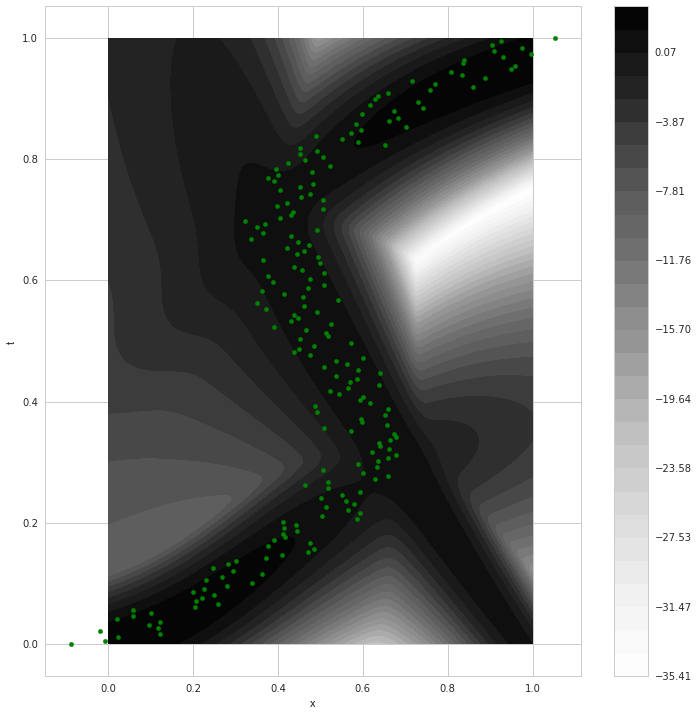

In [560]:
plt.figure( figsize=(12, 12) )
plt.contourf(xm, tm, neg_log_lik.reshape(200, 200), levels=np.linspace(neg_log_lik.min(), neg_log_lik.max(), 30));
plt.colorbar();

plt.scatter(data['x'], data['t'], color='g');
plt.xlabel('x');
plt.ylabel('t');

`[TODO]` How to choose the `#components`